# Policy Based Methods

Until now, we’ve explored methods that can find optimal and near-optimal policies with the help of value functions. However, all of those algorithms learn value functions when what we need are policies. Now, we explore the other side of the spectrum: **methods that optimize policies directly**. 

In value-based methods, the main focus is to learn to evaluate policies. For this, the objective is to minimize a loss between predicted and target values. More specifically, the goal is to match the true value function of a given policy, and therefore, we parameterized a value function and minimized the mean squared error between predicted and target values. Note that we didn’t have true target values, and instead, we used predicted returns. In **policy-based methods**, the objective is to maximize the performance of a **parameterized policy**, so we are running gradient ascent (or regular gradient descent on the negative performance). It’s rather evident that the performance of an agent is the expected total discounted reward from the initial state, which is the same thing as the expected state-value function from all initial states of a given policy:

$\displaystyle J(\theta) = E_{s_0 \sim p_0 } [v_{\pi_{\theta}}(s_0)] $

The main advantage is we can now learn **stochastic policies**, with better performance under **partially observable environments**. The intuition is that because we can learn arbitrary probabilities of actions, the agent is less dependent on the Markov assumption. For example, if the agent can’t distinguish a handful of states from their emitted observations, the best strategy is often to act randomly with specific probabilities:

<img src="./images/stochastic-policies.png" width="800">

Interestingly, with stochastic policies, **exploration can be embedded in the learned function**.

Learning stochastic policies it could be **more straightforward for function approximation**. Sometimes value functions are **too much informative** for what’s truly needed. It could be that calculating the exact value of a state or state-action pair is complicated or unnecessary:

<img src="./images/learning-policies-vs-value-functions.png" width="800">


Finally, value-based methods are **prone to oscillations and even divergence**: tiny changes in value-function space may imply significant changes in action space. A significant difference in actions can create entirely unusual new trajectories, and therefore create instabilities. In policy-based methods, we instead follow the gradient with respect to stochastic policies, which only progressively and smoothly changes the actions. Therefore, policy-based methods often have **better convergence properties**.

How we can learn a policy that optimizes the value function directly, without learning a value function? We know what we want to find the gradient with respect to that performance metric defined before:

$\displaystyle \nabla_\theta J(\theta) = \nabla_\theta E_{s_0 \sim p_0 } [v_{\pi_{\theta}}(s_0)] $

To simplify notation, let’s use $\tau$ as a variable representing the full trajectory:

$\displaystyle \tau = S_0, A_0, R_1, S_1,..., S_{T-1}, A_{T-1}, R_T, S_T $

This way we can abuse notation and use the $G$ function to obtain the return of the full trajectory:

$\displaystyle G(\tau) = R_1 + \gamma R_2 + ... + \gamma^{T-1}R_T $

We can also get the **probability of a trajectory** as the probability of the initial states, then the action, then the transition, and so on until we have the product of all the probabilities that make the trajectory likely:

$\displaystyle p(\tau|\pi_\theta) = p_0(S_0) \pi_\theta(A_0|S_0) P(S_1,R_1|S_0,A_0)...P(S_T,R_T|S_{T-1},A_{T-1}) $

Using this notation, we can rewrite the objective as:

$\displaystyle \nabla_\theta J(\theta) = \nabla_\theta E_{s_0 \sim p_0 } [v_{\pi_{\theta}}(s_0)] = \nabla_\theta E_{\tau \sim \pi_\theta } \left[ G(\tau) \right] $

Now, we can apply a method called **score function gradient estimator** for estimating gradients of expectations:

$\displaystyle \nabla_\theta E_x \left[f(x) \right] = E_x \left[ \nabla_\theta \log  p(x|\theta)f(x))\right] $

With that identity, we can substitute values and get this: 

$\displaystyle \nabla_\theta E_{\tau \sim \pi_\theta} \left[G(\tau) \right] = E_{\tau \sim \pi_\theta} \left[ \nabla_\theta \log  p(\tau|\pi_\theta)G(\tau))\right] $

Notice the dependence on the probability of the trajectory. If we substitute the probability of trajectory, take the logarithm to turn the product into a sum, and differentiate with respect to theta, all dependence on the transition function is dropped, and we’re left with a function that we can work with:

$\displaystyle \nabla_\theta E_{\tau \sim \pi_\theta} \left[G(\tau) \right] = E_{\tau \sim \pi_\theta} \left[\sum\limits_{t=0}^{T}{\nabla_\theta \log \pi_\theta(A_t|S_t) G(\tau)}  \right] $

We have a way to compute the policy gradient without knowing anything about the environment’s transition function: we first collect a full trajectory $\tau$ and calculate the full discounted return $G(\tau)$ and then we use that to weight the log probabilities of every action taken in that trajectory: $A_t, A_{t+1},..., A_{T–1}$. However, this is counterintuitive because we’re increasing the likelihood of action A2 in the same proportion as action A0, even if the return after A0 is greater than the return after A2:

<img src="./images/g_tau.png" width="600">

We know we can’t go back in time and current actions cannot be responsible for past reward. So, we can do something about that. For each step $t$ in the trajectory, we calculate the return just from that step $G_t(\tau)$ and use that value as the score to weight the log probability of the action taken at that time step:

$\displaystyle \nabla_\theta J(\theta) = E_{\tau \sim \pi_\theta} \left[\sum\limits_{t=0}^{T}{G_t({\tau})\nabla_\theta \log \pi_\theta(A_t|S_t)}  \right] $


## REINFORCE 

The REINFORCE algorith ([R.J. Williams, **"Simple Statistical Gradient-Following Algorithms for Connectionist Reinforcement Learning"**, Machine Learning (1992)](https://link.springer.com/article/10.1007/BF00992696)) try to estimate the gradient using the full Monte Carlo returns. We can write it in Python, first a fully connected network and then the algorithm:

In [21]:
import torch.nn as nn
import torch.nn.functional as F

class FCR(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=(32,32), activation=F.relu):
        super(FCR, self).__init__()
        self.activation = activation

        # defining the input layer
        self.input_layer = nn.Linear(input_dim, hidden_dims[0])

        # creating the hidden layers 
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
        
        # connecting the output layer 
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)

        # decide the device to be used
        device = "cpu"
        if torch.cuda.is_available():
            device = "cuda:0"
        self.device = torch.device(device)
        self.to(self.device)
        
    def forward(self, state):
        # take in the raw state and convert it into a tensor
        # also unsqueezing it in order to change it's shape
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, device=self.device, dtype=torch.float32)
            x = x.unsqueeze(0)

        # pass it through the input layer
        x = self.activation(self.input_layer(x))

        # then pass for all hidden layers
        for hidden_layer in self.hidden_layers:
            x = self.activation(hidden_layer(x))
        
        # finally, pass for the output layer
        return self.output_layer(x)
 
    # a handy function to obtain probabilities, actions, and everything 
    # needed for training
    def full_pass(self, state):
        logits = self.forward(state)
        dist = torch.distributions.Categorical(logits=logits)
        action = dist.sample()
        logpa = dist.log_prob(action).unsqueeze(-1)
        entropy = dist.entropy().unsqueeze(-1)
        is_exploratory = action != np.argmax(logits.detach().numpy())
        return action.item(), is_exploratory.item(), logpa, entropy

    # a helper function for when we only need sampled action
    def select_action(self, state):
        logits = self.forward(state)
        dist = torch.distributions.Categorical(logits=logits)
        action = dist.sample()
        return action.item()
    
    # selecting the greedy action according to the policy
    def select_greedy_action(self, state):
        logits = self.forward(state)
        return np.argmax(logits.detach().numpy())
    

XXXX

In [13]:
import numpy as np
import random 
import time
from itertools import count
import torch
import torch.optim as optim

class REINFORCE():
    def __init__(self, env, model, optimizer, seed, gamma):
        self.env = env
        self.model = model
        self.optimizer = optimizer
        self.seed = seed
        self.gamma = gamma

In [14]:
def optimize_model(self):
        
    T = len(self.rewards)
    
    # calculate the discounts as with all Monte Carlo methods
    discounts = np.logspace(0, T, num=T, base=self.gamma, endpoint=False)
    
    # calculate the sum of discounted returns for all time steps
    # notice this is the returns for every time step in the episode,
    # from the initial state at time step 0, to one before the terminal T-1.
    returns = np.array([np.sum(discounts[:T-t] * self.rewards[t:]) for t in range(T)])

    discounts = torch.FloatTensor(discounts).unsqueeze(1)
    returns = torch.FloatTensor(returns).unsqueeze(1)
    self.logpas = torch.cat(self.logpas)

    # calculate the policy loss: the log probability of the actions selected weighted 
    # by the returns obtained after that action was selected. 
    # Notice that because PyTorch does gradient descent by default, we use the 
    # negative mean of the performance to flip the function. 
    # We account for discounted policy gradients, so we multiply the returns by 
    # the discounts
    loss = -(discounts * returns * self.logpas).mean()
    
    # zero the gradients in the optimizer, then do a backward pass, and then step 
    # in the direction of the gradient.
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

REINFORCE.optimize_model = optimize_model

In [15]:
def interaction_step(self, state):
    
    # interact with environment using the policy
    action, is_exploratory, logpa, _ = self.model.full_pass(state)

    # collect an experience tuple as usual 
    new_state, reward, is_terminal, is_truncated, info = self.env.step(action)

    self.logpas.append(logpa)
    self.rewards.append(reward)
    
    self.episode_reward[-1] += reward
    self.episode_timestep[-1] += 1

    # define the end of the episode as terminated or truncated
    is_done = is_terminal or is_truncated

    return new_state, is_done

REINFORCE.interaction_step = interaction_step

Notice that instead of selecting only in a greedy way, we can also sample from the learned stochastic policy.  The correct thing to do here depends on the environment, but sampling is the safe bet.

In [16]:
  
def evaluate(self, n_episodes=1, greedy=True):

     # create a list of returns of each episode
    rs = []

    # loop over the episodes
    for _ in range(n_episodes):

        # reset the environment
        s = self.env.reset()[0]

        # initialize the return
        rs.append(0)

        # interact with the environment until the episode is done 
        while(True):

            # interact with environment using the policy (greed or not)
            if greedy:
                a = self.model.select_greedy_action(s)
            else: 
                a = self.model.select_action(s)
            
            # collect an experience tuple as usual
            s, r, d, t, _ = self.env.step(a)

            # add the reward to the return of the episode
            rs[-1] += r

            if d or t: 
                break
            
    return np.mean(rs), np.std(rs)

REINFORCE.evaluate = evaluate

In [17]:
def train(self, gamma, max_minutes, max_episodes, goal_reward, episodes_window):
    
    # timing variables
    training_start = time.time()
    training_time = 0

    self.gamma = gamma

    # stats trackers 
    self.episode_timestep = []
    self.episode_reward = []
    self.episode_seconds = []
    self.evaluation_scores = []
                        
    result = np.empty((max_episodes, 4))
    result[:] = np.nan
    training_time = 0
    
    # train until we either reach the max minutes, the max episodes or the goal mean reward
    for episode in range(1, max_episodes + 1):

        # get the start time of the episode
        episode_start = time.time()
        
        # reset the episode trackers
        self.episode_reward.append(0.0)
        self.episode_timestep.append(0.0)

        # reset the environment before starting the episode
        state = self.env.reset()[0]
        
        # interact with the environment until the episode is done
        for step in count():
            
            # interact with environment using the exploration policy
            # and collect the experience in the replay memory
            state, is_done = self.interaction_step(state)
            
            if is_done: 
                break
        
        # then, run one optimization step with the batch of all 
        # time steps in the episode
        self.optimize_model()

        # timing stuff
        episode_elapsed = time.time() - episode_start
        self.episode_seconds.append(episode_elapsed)
        training_time += episode_elapsed
        
        # episode steps count
        total_step = int(np.sum(self.episode_timestep))

        # evaluate the learned policy after the episode
        evaluation_score, _ = self.evaluate()
        self.evaluation_scores.append(evaluation_score)

        # average stats over some recent episodes
        mean_train_reward = np.mean(self.episode_reward[-episodes_window:])
        std_train_reward = np.std(self.episode_reward[-episodes_window:])
        mean_eval_score = np.mean(self.evaluation_scores[-episodes_window:])
        std_eval_score = np.std(self.evaluation_scores[-episodes_window:])

        # report results
        result[episode-1] = total_step, mean_train_reward, mean_eval_score, training_time

        # check max episodes, max minutes and goal achievement criteria
        total_elapsed = time.time() - training_start
        reached_max_minutes = total_elapsed >= max_minutes * 60
        reached_max_episodes = episode >= max_episodes
        reached_goal_mean_reward = mean_eval_score >= goal_reward
        training_is_over = reached_max_minutes or reached_max_episodes or reached_goal_mean_reward

        # informative print logging  
        debug_message = 'episode {:04}, steps {:06}, avg eval score {:05.1f} (+/- {:05.1f})'
        debug_message = debug_message.format(episode, total_step, mean_eval_score, std_eval_score)
        print(debug_message, end='\r', flush=True)
        
        # conclude training if we have met any of the stopping conditions
        if training_is_over:
            print(debug_message)
            if reached_max_minutes: print(u'--> reached_max_minutes ')
            if reached_max_episodes: print(u'--> reached_max_episodes ')
            if reached_goal_mean_reward: print(u'--> reached_goal_mean_reward ')
            break
            
    # evaluate the final policy
    final_eval_score, final_eval_std = self.evaluate(n_episodes=episodes_window)
    
    return result, final_eval_score, final_eval_std, training_time

REINFORCE.train = train

The REINFORCE algorithm works well in simple problems, and it has convergence guarantees. But because it uses the full Monte Carlo returns for calculating the gradient, its variance is a problem. The accumulation of random events along a trajectory and the randomness of the action selection is compounded inside the return, making it a high variance signal that's challenging to interpret.

We can try the algorithm in the cart-pole environment:

In [18]:
import gymnasium
cartpole = gymnasium.make('CartPole-v1')

In [19]:
def experiment(algorithm, network, env, gamma=1, 
               max_minutes=20, max_episodes=10000, goal_reward=475, episodes_window=25,
               hidden_dims=(128,64), learning_rate=0.0005,
               replay_memory_max_size=50000, replay_memory_batch_size=64,
               init_epsilon=1.0, min_epsilon=0.3, decay_steps=20000,
               target_update_steps=10, n_warmup_batches=5,
               seeds=(12, 34, 56, 78, 90)):
    
    results = []
    best_agent = None 
    best_eval_score = float('-inf')
    
    for seed in seeds:
        print('Training started...')

        # set the seeds for reproducibility of results
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        env.np_random = np.random.Generator(np.random.PCG64(seed))

        # create models, optimizer, reply buffer and strategies
        nS, nA = env.observation_space.shape[0], env.action_space.n
        model = FCR(nS, nA, hidden_dims)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        
        # create the agent
        agent = REINFORCE(env, model, optimizer, seed, gamma)

        # train the agent
        result, score, score_std, training_time = agent.train(gamma, max_minutes, max_episodes, goal_reward, episodes_window)
    
        # save the results the best agent
        results.append(result)
        if score > best_eval_score:
            best_eval_score = score
            best_agent = agent

        print('...training complete.')
        print('Final evaluation score {:.2f}\u00B1{:.2f} in {:.2f}s training time\n'.format(score, score_std, training_time))

    return np.array(results), best_agent, best_eval_score

In [22]:
reinforce_results, reinforce_agent, reinforce_score = experiment(REINFORCE, FCR, cartpole)

Training started...


AttributeError: 'REINFORCE' object has no attribute 'logpas'

## Vanilla Policy Gradient (VPG)

A way for reducing the variance of REINFORCE is to use partial returns instead of the full return for changing the log probabilities of actions. However, the action log probabilities change in the proportion of the return. This means that, if we receive a significant positive return, the probabilities of the actions that led to that return are increased by a large margin. And if the return is of significant negative magnitude, then the probabilities are decreased by of large margin. However, imagine an environment (such as the cart-pole) in which all rewards and returns are positive. In order to accurately separate okay actions from the best actions, we need a lot of data. The variance is, otherwise, hard to muffle. It would be handy if we could, instead of using noisy returns, use something that allows us to differentiate the values of actions in the same state: remember the definition of the true action-advantage function:

$\begin{align}
a_\pi(s,a) = q_\pi(s,a) - v_\pi(s)
\end{align}$

we can say that the advantage function is approximately the following:

$\begin{align}
A(S_t,A_t) = R_t + \gamma R_{t+1} + ... + \gamma^{T-1} R_T - v_\pi(S_t)
\end{align}$

A not-too-bad estimate of it is the return $G_t$ minus the estimated expected return from that state. We can use this easily:

$\begin{align}
A(S_t,A_t) = G_t - V(S_t)
\end{align}$

So, we can reduce the variance of the policy gradient by using an estimate of the action-advantage function, instead of the actual return. Using the advantage somewhat centers scores around zero; better-than-average actions have a positive score, worse-than-average, a negative score. The former decreases the probabilities, and the latter increases them.
We’re going to do exactly that: let’s now create two neural networks, one for learning the
policy, the other for learning a state-value function: 

<img src="./images/policy-and-value-network.png" width="600">


Is this still a "policy-based" method? It’s learning a policy but also a value-function. According to Rich Sutton, "policy-based methods" approximate the gradient of the performance measure, whether or not they learn an approximate value function. 

Another essential improvement is to add an **entropy term** to to the loss function to **encourage having evenly distributed actions**. In this way, the agent had better converge to the optimal action. So, this is the loss for the value function (the mean squared Monte Carlo error:

$\begin{align}
L_v(\phi)=\frac{1}{N}\sum\limits_{n=0}^{N}{\left[\left(G_t-V(S_t;\phi)\right)^2\right]} 
\end{align}$

and this is the loss of the policy (the estimated advantage weighted by the log probability of the action taken plus the entropy term):

$\begin{align}
L_\pi(\theta)=\frac{1}{N}\sum\limits_{n=0}^{N}{\left[\left(G_t-V(S_t;\phi)\right) \log \pi(A_t|S_t;\theta) + \beta H(\pi(S_t;\theta))\right]}\end{align}$

We can implement in Python this algorithm called **Vanilla policy gradient***. First of all, we implement a state-value function neural network,  similar to the Q-function network we used in the past:

In [23]:
class FCV(nn.Module):
    def __init__(self, input_dim, hidden_dims=(32,32), activation_fc=F.relu):
        super(FCV, self).__init__()
        self.activation_fc = activation_fc

        self.input_layer = nn.Linear(input_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
            
        self.output_layer = nn.Linear(hidden_dims[-1], 1)

    def forward(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float32)
            x = x.unsqueeze(0)
        x = self.activation_fc(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc(hidden_layer(x))
        return self.output_layer(x)

An then the algorithm code:

In [32]:
class VPG():
    def __init__(self, env, policy_model, policy_optimizer, 
                 value_model, value_optimizer, 
                 entropy_loss_weight, seed, gamma):
        
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        env.seed(seed)
        
        self.env = env
        self.policy_model = policy_model
        self.policy_optimizer = policy_optimizer        
        self.value_model = value_model
        self.value_optimizer = value_optimizer
        self.entropy_loss_weight = entropy_loss_weight
        self.gamma = gamma
        self.seed = seed

    def optimize_model(self):
        T = len(self.rewards)
        discounts = np.logspace(0, T, num=T, base=self.gamma, endpoint=False)
        
        # this loop is going through all steps from 0, then 1, 2, 3 all the
        # way to the terminal state T , and calculating the return from that state, 
        # which is the sum of discounted rewards from that state at time step t to 
        # the terminal state T
        returns = np.array([np.sum(discounts[:T-t] * self.rewards[t:]) for t in range(T)])
        discounts = torch.FloatTensor(discounts[:-1]).unsqueeze(1)
        returns = torch.FloatTensor(returns[:-1]).unsqueeze(1)

        self.logpas = torch.cat(self.logpas)
        self.entropies = torch.cat(self.entropies) 
        self.values = torch.cat(self.values)

        # calculate the value error; then use it to score the log probabilities 
        # of the actions. Then, discount these to be compatible with the 
        # discounted policy gradient. Then, use the negative mean.
        value_error = returns - self.values
        policy_loss = -(discounts * value_error.detach() * self.logpas).mean()
        
        # calculate the entropy, and add a fraction to the loss.
        entropy_loss = -self.entropies.mean()
        loss = policy_loss + self.entropy_loss_weight * entropy_loss
        
        # optimize the policy: zero the optimizer, do the backward pass
        self.policy_optimizer.zero_grad()
        loss.backward()
        self.policy_optimizer.step()

        # last,optimize the value-function neural network.
        value_loss = value_error.pow(2).mul(0.5).mean()
        self.value_optimizer.zero_grad()
        value_loss.backward()
        self.value_optimizer.step()
        
    def interaction_step(self, state):
        action, is_exploratory, logpa, entropy = self.policy_model.full_pass(state)
        new_state, reward, is_terminal, info = self.env.step(action)
        is_truncated = 'TimeLimit.truncated' in info and info['TimeLimit.truncated']

        self.logpas.append(logpa)
        self.entropies.append(entropy)
        self.rewards.append(reward)
        self.values.append(self.value_model(state))

        self.episode_reward[-1] += reward
        self.episode_timestep[-1] += 1
        self.episode_exploration[-1] += int(is_exploratory)
        return new_state, is_terminal, is_truncated

    def train(self, max_minutes, max_episodes, goal_mean_100_reward):
        training_start, last_debug_time = time.time(), float('-inf')
        
        self.episode_timestep = []
        self.episode_reward = []
        self.episode_seconds = []
        self.episode_exploration = []
        self.evaluation_scores = []

        result = np.empty((max_episodes, 4))
        result[:] = np.nan
        training_time = 0
        
        for episode in range(1, max_episodes + 1):
            episode_start = time.time()
            
            state, is_terminal = env.reset(), False
            self.episode_reward.append(0.0)
            self.episode_timestep.append(0.0)
            self.episode_exploration.append(0.0)

            self.logpas, self.entropies, self.rewards, self.values = [], [], [], []
            for step in count():
                state, is_terminal, is_truncated = self.interaction_step(state)
                if is_terminal:
                    break

            is_failure = is_terminal and not is_truncated
            next_value = 0 if is_failure else self.value_model(state).detach().item()
            self.rewards.append(next_value)
            self.optimize_model()

            # stats
            episode_elapsed = time.time() - episode_start
            self.episode_seconds.append(episode_elapsed)
            training_time += episode_elapsed
            evaluation_score, _ = self.evaluate()
            total_step = int(np.sum(self.episode_timestep))
            self.evaluation_scores.append(evaluation_score)
            
            mean_100_train_reward = np.mean(self.episode_reward[-100:])
            std_100_train_reward = np.std(self.episode_reward[-100:])
            mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
            std_100_eval_score = np.std(self.evaluation_scores[-100:])

            result[episode-1] = total_step, mean_100_train_reward, mean_100_eval_score, training_time
            
            total_elapsed = time.time() - training_start
            reached_debug_time = time.time() - last_debug_time >= 60
            reached_max_minutes = total_elapsed >= max_minutes * 60
            reached_max_episodes = episode >= max_episodes
            reached_goal_mean_reward = mean_100_eval_score >= goal_mean_100_reward
            training_is_over = reached_max_minutes or reached_max_episodes or reached_goal_mean_reward
            
            total_elapsed = time.time() - training_start
            reached_debug_time = time.time() - last_debug_time >= 60
            reached_max_minutes = total_elapsed >= max_minutes * 60
            reached_max_episodes = episode >= max_episodes
            reached_goal_mean_reward = mean_100_eval_score >= goal_mean_100_reward
            
            debug_message = 'episode {:04}, steps {:06}, '
            debug_message += 'avg score {:05.1f}\u00B1{:05.1f}, '
            debug_message = debug_message.format(episode-1, total_step, mean_100_train_reward, std_100_train_reward)
            print(debug_message, end='\r', flush=True)
                   
            if reached_debug_time or training_is_over:
                print(debug_message, flush=True)
                last_debug_time = time.time()
            
            if training_is_over:
                if reached_max_minutes: print(u'--> reached_max_minutes')
                if reached_max_episodes: print(u'--> reached_max_episodes')
                if reached_goal_mean_reward: print(u'--> reached_goal_mean_reward')
                break
                
        final_eval_score, final_eval_std = self.evaluate(n_episodes=100)
        
        return result, final_eval_score, final_eval_std, training_time

    def evaluate(self, n_episodes=1, greedy=True):
        rs = []
        for _ in range(n_episodes):
            s, d = self.env.reset(), False
            rs.append(0)
            for _ in count():
                if greedy:
                    a = self.policy_model.select_greedy_action(s)
                else: 
                    a = self.policy_model.select_action(s)
                s, r, d, _ = self.env.step(a)
                rs[-1] += r
                if d: break
        return np.mean(rs), np.std(rs)


We can try the algorithm in the cart-pole environment:

In [33]:
vanilla_results = []
best_vanilla_agent, best_vanilla_eval_score = None, float('-inf')

gamma = 1.00
max_minutes = 20
max_episodes = 10000
goal_mean_100_reward = 475

nS, nA = env.observation_space.shape[0], env.action_space.n

for seed in (12, 34, 56, 78, 90):
    
    print('Training started...')

    policy_model = FCR(nS, nA, hidden_dims=(128,64))
    policy_optimizer = optim.Adam(policy_model.parameters(), lr=0.0005)
    
    value_model = FCV(nS, hidden_dims=(256,128))
    value_optimizer = optim.RMSprop(value_model.parameters(), lr=0.0007)
    
    entropy_loss_weight = 0.001
            
    agent = VPG(env, policy_model, policy_optimizer, value_model, value_optimizer,
                entropy_loss_weight, seed, gamma)
    
    result, score, score_std, training_time = agent.train(max_minutes, max_episodes, goal_mean_100_reward)
    
    vanilla_results.append(result)
    
    if score > best_vanilla_eval_score:
        best_vanilla_eval_score = score
        best_vanilla_agent = agent
        
vanilla_results = np.array(vanilla_results)

Training started...
episode 0000, steps 000023, avg score 023.0±000.0, 
episode 0369, steps 068535, avg score 361.5±146.6, 
episode 0390, steps 078372, avg score 418.4±117.4, 
--> reached_goal_mean_reward
Training started...
episode 0000, steps 000017, avg score 017.0±000.0, 
episode 0357, steps 070184, avg score 369.6±130.8, 
episode 0385, steps 083453, avg score 432.4±104.9, 
--> reached_goal_mean_reward
Training started...
episode 0000, steps 000010, avg score 010.0±000.0, 
episode 0379, steps 069803, avg score 385.1±126.3, 
episode 0390, steps 074903, avg score 403.3±121.0, 
--> reached_goal_mean_reward
Training started...
episode 0000, steps 000011, avg score 011.0±000.0, 
episode 0308, steps 043936, avg score 327.9±126.3, 
--> reached_goal_mean_reward
Training started...
episode 0000, steps 000014, avg score 014.0±000.0, 
episode 0328, steps 069350, avg score 380.5±139.8, 
episode 0340, steps 074908, avg score 419.3±112.7, 
--> reached_goal_mean_reward


## REINFORCE vs VPG


In [35]:
reinforce_max_steps, reinforce_max_train_reward, reinforce_max_eval_score, reinforce_max_time = np.max(reinforce_results, axis=0).T
reinforce_min_steps, reinforce_min_train_reward, reinforce_min_eval_score, reinforce_min_time = np.min(reinforce_results, axis=0).T
reinforce_mean_steps, reinforce_mean_train_reward, reinforce_mean_eval_score, reinforce_mean_time = np.mean(reinforce_results, axis=0).T
reinforce_episodes = np.arange(len(reinforce_mean_steps))

In [36]:
vanilla_max_steps, vanilla_max_train_reward, vanilla_max_eval_score, vanilla_max_time = np.max(vanilla_results, axis=0).T
vanilla_min_steps, vanilla_min_train_reward, vanilla_min_eval_score, vanilla_min_time = np.min(vanilla_results, axis=0).T
vanilla_mean_steps, vanilla_mean_train_reward, vanilla_mean_eval_score, vanilla_mean_time = np.mean(vanilla_results, axis=0).T
vanilla_episodes = np.arange(len(vanilla_mean_steps))

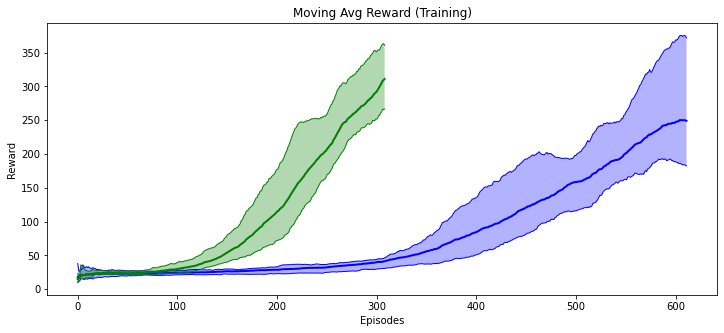

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.plot(reinforce_max_train_reward, 'b', linewidth=1)
plt.plot(reinforce_min_train_reward, 'b', linewidth=1)
plt.plot(reinforce_mean_train_reward, 'b', linewidth=2)
plt.fill_between(reinforce_episodes, reinforce_min_train_reward, reinforce_max_train_reward, facecolor='b', alpha=0.3)

plt.plot(vanilla_max_train_reward, 'g', linewidth=1)
plt.plot(vanilla_min_train_reward, 'g', linewidth=1)
plt.plot(vanilla_mean_train_reward, 'g', linewidth=2)
plt.fill_between(vanilla_episodes, vanilla_min_train_reward, vanilla_max_train_reward, facecolor='g', alpha=0.3)

plt.title('Moving Avg Reward (Training)')
plt.ylabel('Reward')
plt.xlabel('Episodes')
plt.show()

Notice how VPG is more sample efficient, instead REINFORCE is too inefficient to be a practical algorithm.

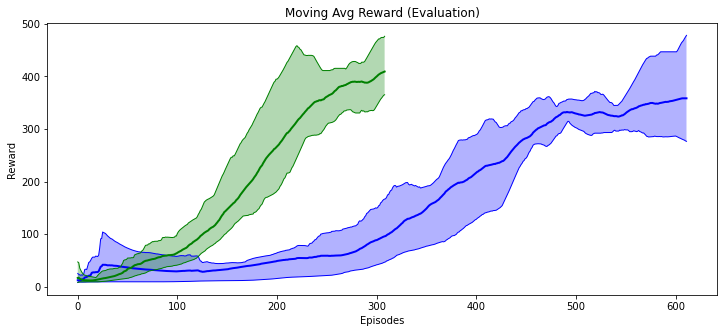

In [38]:
plt.figure(figsize=(12,5))

plt.plot(reinforce_max_eval_score, 'b', linewidth=1)
plt.plot(reinforce_min_eval_score, 'b', linewidth=1)
plt.plot(reinforce_mean_eval_score, 'b', linewidth=2)
plt.fill_between(reinforce_episodes, reinforce_min_eval_score, reinforce_max_eval_score, facecolor='b', alpha=0.3)

plt.plot(vanilla_max_eval_score, 'g', linewidth=1)
plt.plot(vanilla_min_eval_score, 'g', linewidth=1)
plt.plot(vanilla_mean_eval_score, 'g', linewidth=2)
plt.fill_between(vanilla_episodes, vanilla_min_eval_score, vanilla_max_eval_score, facecolor='g', alpha=0.3)

plt.title('Moving Avg Reward (Evaluation)')
plt.ylabel('Reward')
plt.xlabel('Episodes')
plt.show()

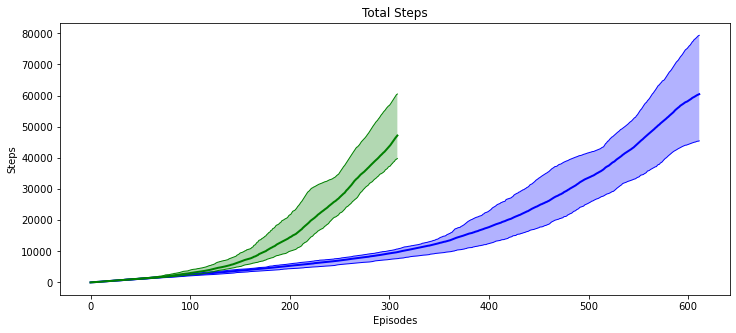

In [39]:
plt.figure(figsize=(12,5))

plt.plot(reinforce_max_steps, 'b', linewidth=1)
plt.plot(reinforce_min_steps, 'b', linewidth=1)
plt.plot(reinforce_mean_steps, 'b', linewidth=2)
plt.fill_between(reinforce_episodes, reinforce_min_steps, reinforce_max_steps, facecolor='b', alpha=0.3)

plt.plot(vanilla_max_steps, 'g', linewidth=1)
plt.plot(vanilla_min_steps, 'g', linewidth=1)
plt.plot(vanilla_mean_steps, 'g', linewidth=2)
plt.fill_between(vanilla_episodes, vanilla_min_steps, vanilla_max_steps, facecolor='g', alpha=0.3)

plt.title('Total Steps')
plt.ylabel('Steps')
plt.xlabel('Episodes')
plt.show()

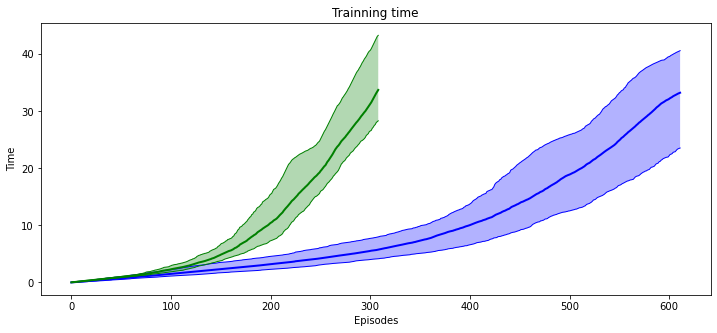

In [40]:
plt.figure(figsize=(12,5))

plt.plot(reinforce_max_time, 'b', linewidth=1)
plt.plot(reinforce_min_time, 'b', linewidth=1)
plt.plot(reinforce_mean_time, 'b', linewidth=2)
plt.fill_between(reinforce_episodes, reinforce_min_time, reinforce_max_time, facecolor='b', alpha=0.3)

plt.plot(vanilla_max_time, 'g', linewidth=1)
plt.plot(vanilla_min_time, 'g', linewidth=1)
plt.plot(vanilla_mean_time, 'g', linewidth=2)
plt.fill_between(vanilla_episodes, vanilla_min_time, vanilla_max_time, facecolor='g', alpha=0.3)

plt.title('Trainning time')
plt.ylabel('Time')
plt.xlabel('Episodes')
plt.show()

VPG is a pretty robust method for simple problems; it is, for the most part, unbiased because it uses an unbiased target for learning both the policy and value function. That is, it uses Monte Carlo returns, which are complete actual returns experienced directly in the environment, without any bootstrapping. The only bias in the entire algorithm is because we use function approximation, which is inherently biased.